In [1]:
# !pip install ../input/vitkerasprerequisites/validators-0.18.2-py3-none-any.whl
# !pip install ../input/vitkerasprerequisites/vit_keras-0.1.0-py3-none-any.whl
!pip install vit-keras

# !pip install ../input/libjpeg-gdcm/pylibjpeg_libjpeg-1.3.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install pylibjpeg-libjpeg

# !pip install ../input/libjpeg-gdcm/python_gdcm-3.0.15-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install python-gdcm

  Preparing metadata (setup.py) ... - done
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19582 sha256=b9ade3abe792e954d53719c6052bb04d3087f8de8b3286390ead2f35f252492a
  Stored in directory: /root/.cache/pip/wheels/5f/55/ab/36a76989f7f88d9ca7b1f68da6d94252bb6a8d6ad4f18e04e9
Successfully built validators
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 15.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import cv2
import pydicom 
import matplotlib.pyplot as plt
import glob
import os
import random
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow import keras
from vit_keras import vit, utils
import tensorflow_addons as tfa
import albumentations as A
import ast
import gc
gc.enable()

In [3]:
cfg = {
    'train_df': '../input/rsna-2022-cervical-spine-fracture-detection/train.csv',
    'test_df': '../input/rsna-2022-cervical-spine-fracture-detection/test.csv',
    'batch_size': 128,
    'lr': 1e-04,
    'img_size': 258, 
    'vit_img_size': 256,
    'epochs': 25,
    'model_path': '../input/trial/best_model.h5'
}

# Data Preparation

In [4]:
data_df = pd.read_csv('../input/rsna-data/full_data.csv', dtype={"patient_overall": str})
data_df.head()

,img_paths,C_labels,patient_overall
0,../input/rsna-2022-cervical-spine-fracture-det...,"[0, 1, 0, 0, 0, 0, 0]",1
1,../input/rsna-2022-cervical-spine-fracture-det...,"[0, 1, 0, 0, 0, 0, 0]",1
2,../input/rsna-2022-cervical-spine-fracture-det...,"[0, 1, 0, 0, 0, 0, 0]",1
3,../input/rsna-2022-cervical-spine-fracture-det...,"[0, 1, 0, 0, 0, 0, 0]",1
4,../input/rsna-2022-cervical-spine-fracture-det...,"[0, 1, 0, 0, 0, 0, 0]",1


In [5]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711601 entries, 0 to 711600
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   img_paths        711601 non-null  object
 1   C_labels         711601 non-null  object
 2   patient_overall  711601 non-null  object
dtypes: object(3)
memory usage: 16.3+ MB


In [6]:
data_df = data_df.sample(frac=1.0, random_state=42).reset_index(drop=True)
data_sample = data_df[:15000]

In [7]:
try:
    sample_train_df, sample_valid_df = train_test_split(data_sample, test_size=0.2, random_state=42, shuffle=True)
    sample_train_df.reset_index(drop=True, inplace=True); sample_valid_df.reset_index(drop=True, inplace=True)
    del data_sample, data_df; gc.collect()
    sample_train_df.head()
except: 
    data_df = pd.read_csv('../input/rsna-data/full_data.csv', dtype={"patient_overall": str})
    data_df = data_df.sample(frac=1.0, random_state=42).reset_index(drop=True)
    data_sample = data_df[:15000]
    sample_train_df, sample_valid_df = train_test_split(data_sample, test_size=0.2, random_state=42, shuffle=True)
    sample_train_df.reset_index(drop=True, inplace=True); sample_valid_df.reset_index(drop=True, inplace=True)
    del data_sample, data_df; gc.collect()
sample_train_df.head()
#sample_valid_df.head()

,img_paths,C_labels,patient_overall
0,../input/rsna-2022-cervical-spine-fracture-det...,"[0, 0, 0, 0, 0, 0, 0]",0
1,../input/rsna-2022-cervical-spine-fracture-det...,"[0, 0, 0, 0, 0, 0, 0]",0
2,../input/rsna-2022-cervical-spine-fracture-det...,"[0, 0, 0, 0, 1, 1, 0]",1
3,../input/rsna-2022-cervical-spine-fracture-det...,"[0, 0, 0, 0, 0, 0, 0]",0
4,../input/rsna-2022-cervical-spine-fracture-det...,"[0, 0, 0, 0, 0, 0, 1]",1


# Data Pipeline

In [8]:
class DataPipeLine(Sequence):
    def __init__(
        self,
        df,
        batch_size = cfg['batch_size'],
        img_size = cfg['img_size'],
        shuffle = True,
        augments = True
    ):
        self.df = df
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augments = augments
        self.transforms = A.Compose([
            A.GaussNoise(p=0.25),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.OneOf([
                A.RandomCrop(width=self.img_size, height=self.img_size, p=1.0),
                A.RandomResizedCrop(height=self.img_size, width=self.img_size, p = 1.0)
            ], p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.RandomRotate90(p=0.25)
        ])
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1.0, random_state=42).reset_index(drop=True)
        return self.df
    
    def __len__(self):
        return len(self.df) // self.batch_size
    
    def __getitem__(self, idx):
        X, Y = [], []
        batch = self.df[idx * self.batch_size: (idx+1)*self.batch_size]
        for _, row in batch.iterrows():
            #row = self.df.loc[i]
            data = pydicom.dcmread(row['img_paths'])
            img = pydicom.pixel_data_handlers.util.apply_voi_lut(data.pixel_array, data)
            img = cv2.resize(img, (self.img_size, self.img_size)).reshape((self.img_size, self.img_size, 1))
            #img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            img = img.astype(np.float32)
            label = ast.literal_eval(row['C_labels'])
            label.append(int(row['patient_overall']))
            if self.augments:
                img = self.transforms(image=img)['image']
            X.append(img); Y.append(label)
        return np.array(X), np.array(Y).astype(np.float32)
#     def __call__(self):
#         for idx in range(self.__len__()):
#             yield self.__getitem__(idx)

In [9]:
# train_data = tf.data.Dataset.from_generator(
#     DataPipeLine(sample_train_df),
#     output_types=(tf.float32, tf.float32),
#     output_shapes=((cfg['img_size'], cfg['img_size'], 1), (8,))
# )

# valid_data = tf.data.Dataset.from_generator(
#     DataPipeLine(sample_valid_df),
#     output_types=(tf.float32, tf.float32),
#     output_shapes=((cfg['img_size'], cfg['img_size'], 1), (8,))
# )

# at = tf.data.AUTOTUNE
# train_data = train_data.prefetch(at).batch(cfg['batch_size'])
# valid_data = valid_data.prefetch(at).batch(cfg['batch_size'])
train_data = DataPipeLine(sample_train_df)
valid_data = DataPipeLine(sample_valid_df, augments = False)

# Models

In [10]:
def ResNet_BiLSTM_Model(bilstm=256, weights = 'imagenet', augments=False):
    input_tensor = keras.layers.Input(shape=(cfg['img_size'], cfg['img_size'], 1))
    if augments:
        x = keras.layers.experimental.preprocessing.RandomFlip('horizontal')(input_tensor)
        x = keras.layers.experimental.preprocessing.RandomContrast(0.1, seed=0)(x)
        x = keras.layers.experimental.preprocessing.RandomRotation(factor=0.25, seed=0)(x)
        x = keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.2, width_factor=0.1, seed=0)(x)
        x = keras.layers.Conv2D(3, 3, padding='valid')(x)
        x = keras.applications.ResNet50V2(weights=weights, include_top=False)(x)
        
    else:
        x = keras.layers.Conv2D(3, 3, padding='valid')(input_tensor)
        x = keras.applications.ResNet50V2(weights=weights, include_top=False)(x)
    
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Reshape((2048, 1))(x)
    x = keras.layers.Bidirectional(keras.layers.LSTM(bilstm, return_sequences=False, activation='relu'))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(8, activation='sigmoid')(x)
    
    return keras.models.Model(inputs=input_tensor, outputs=x)



def ViT_Model():
    Vit = vit.vit_b32(
        image_size = (cfg['vit_img_size'], cfg['vit_img_size']),
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        weights='imagenet21k+imagenet2012',
        classes = 1000)

    model = tf.keras.Sequential([
#             tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal', seed=0),
#             tf.keras.layers.experimental.preprocessing.RandomFlip('vertical', seed=15),
#             tf.keras.layers.experimental.preprocessing.RandomContrast(0.1, seed=30),
#             tf.keras.layers.experimental.preprocessing.RandomTranslation(0.1, 0.1, seed=45),
#             tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.25, seed=60),
#             tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.2, width_factor=0.1, seed=75),
            tf.keras.layers.Conv2D(3, 3, padding='valid', input_shape=(cfg['img_size'], cfg['img_size'], 1)),
            Vit,
            tf.keras.layers.Flatten(),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(64, activation = tfa.activations.gelu),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(8, 'sigmoid')
        ], name = 'vision_transformer'
    )
    model.build(input_shape=(None, cfg['img_size'], cfg['img_size'], 1))
    return model
    

def competiton_loss(y_true, y_pred):

    competition_weights = {
        '-' : tf.constant([1, 1, 1, 1, 1, 1, 1, 7], dtype=tf.float32),
        '+' : tf.constant([2, 2, 2, 2, 2, 2, 2, 14], dtype=tf.float32)
    }
    
    loss = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(tf.expand_dims(y_true, -1),tf.expand_dims(y_pred,-1))
    weights  = y_true*competition_weights['+'] + (1-y_true)*competition_weights['-'] 
    
    loss = tf.reduce_mean(tf.reduce_sum(loss * weights, axis=1)) / tf.reduce_sum(weights)
    return loss

#model = tf.keras.models.load_model(cfg['model_path'], custom_objects={'competiton_loss': competiton_loss}, compile=False)
model = ViT_Model()
model.summary()

2022-10-08 04:44:27.748484: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-08 04:44:27.852530: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-08 04:44:27.853397: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-08 04:44:27.854842: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

353263616/353253686 [==============================] - 58s 0us/step


/opt/conda/lib/python3.7/site-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 12, 12 to 8, 8
  UserWarning,


Model: "vision_transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 3)       30        
_________________________________________________________________
vit-b32 (Functional)         (None, 768)               87466752  
_________________________________________________________________
flatten (Flatten)            (None, 768)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 768)               3072      
_________________________________________________________________
dense (Dense)                (None, 64)                49216     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 8)          

In [11]:
model.compile(
    optimizer=tfa.optimizers.RectifiedAdam(learning_rate=cfg['lr']),
    loss= competiton_loss,
    #metrics = ['accuracy']
)

checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/best_model.h5',
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.9,
    min_lr=1e-07,
    patience=3,
    verbose=0,
    mode='min'
)

es = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0,
    monitor='val_loss',
    restore_best_weights=True,
    verbose=0,
    mode='min',
    baseline=None
)

history = model.fit(
    train_data, 
    validation_data=valid_data,
    epochs = cfg['epochs'],
    callbacks=[es,reduce_lr,checkpoint],
    verbose=1
)

2022-10-08 04:45:37.232690: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2022-10-08 04:46:26.531218: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


93/93 [==============================] - 362s 3s/step - loss: 0.0061 - val_loss: 0.0052
Epoch 2/25
93/93 [==============================] - 252s 3s/step - loss: 0.0056 - val_loss: 0.0055
Epoch 3/25
93/93 [==============================] - 196s 2s/step - loss: 0.0054 - val_loss: 0.0055
Epoch 4/25
93/93 [==============================] - 184s 2s/step - loss: 0.0054 - val_loss: 0.0055
Epoch 5/25
93/93 [==============================] - 185s 2s/step - loss: 0.0053 - val_loss: 0.0054
Epoch 6/25
93/93 [==============================] - 184s 2s/step - loss: 0.0053 - val_loss: 0.0054


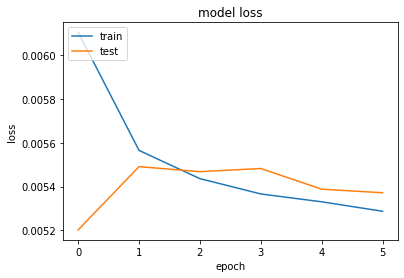

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# References:
1) Loss function: https://www.kaggle.com/code/vmuzhichenko/rsna-22-resnet-50-3d-train